# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
!https_proxy=http://proxy.tmi.alcf.anl.gov:3128  pip install image-dataset-loader
!https_proxy=http://proxy.tmi.alcf.anl.gov:3128  wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
!tar -xf cifar10.tgz

Defaulting to user installation because normal site-packages is not writeable
--2022-10-05 11:34:55--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving proxy.tmi.alcf.anl.gov (proxy.tmi.alcf.anl.gov)... 10.236.1.189
Connecting to proxy.tmi.alcf.anl.gov (proxy.tmi.alcf.anl.gov)|10.236.1.189|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz.6’

cifar10.tgz.6       100%[===================>] 128.85M  52.7MB/s    in 2.4s    

2022-10-05 11:34:58 (52.7 MB/s) - ‘cifar10.tgz.6’ saved [135107811/135107811]



In [3]:
from image_dataset_loader import load
(x_train, y_train), (x_test, y_test) = load('cifar10', ['train', 'test'])

x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('CIFAR-10 data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


CIFAR-10 data loaded: train: 50000 test: 10000
X_train: (50000, 32, 32, 3)
y_train: (50000,)


In [4]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
#x_train = x_train.astype(numpy.float32)
#x_test  = x_test.astype(numpy.float32)

#x_train /= 255.
#x_test  /= 255.

#y_train = y_train.astype(numpy.int32)
#y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the digit images directly to the model.
    - The two Conv2D layers belows learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

In [5]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [6]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [7]:
# This took 55 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/3
98/98 [==============================] - 3s 9ms/step - loss: 1.8141 - accuracy: 0.3410
Epoch 2/3
98/98 [==============================] - 1s 7ms/step - loss: 1.4499 - accuracy: 0.4795
Epoch 3/3
98/98 [==============================] - 1s 7ms/step - loss: 1.3270 - accuracy: 0.5290


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

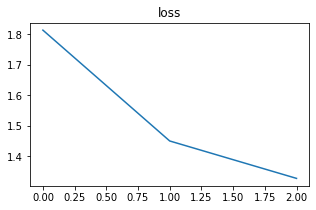

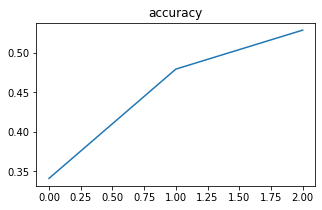

In [8]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 99%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). Even more results can be found [here](http://yann.lecun.com/exdb/mnist/).

In [9]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 1.1532 - accuracy: 0.6010 - 521ms/epoch - 2ms/step
accuracy: 60.10%
CPU times: user 806 ms, sys: 77.4 ms, total: 883 ms
Wall time: 635 ms


We can also again check the confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 858us/step
[[679  16  72  32  15  13  13  18  73  69]
 [ 43 619  11  14   4   5   9  17  44 234]
 [ 83   5 413  77 108 150  75  56  11  22]
 [ 18   4  61 380  57 299  85  57   9  30]
 [ 35   4 117  76 439  79  86 151   6   7]
 [ 15   1  59 151  40 626  16  77   5  10]
 [  5   4  47  84  65  36 708  26   6  19]
 [ 15   0  29  48  43 110   8 716   4  27]
 [142  46  23  34   1  14   9  14 661  56]
 [ 43  55  10  24   4  14  12  32  37 769]]

Classification accuracy for each class:

0: 0.6790
1: 0.6190
2: 0.4130
3: 0.3800
4: 0.4390
5: 0.6260
6: 0.7080
7: 0.7160
8: 0.6610
9: 0.7690


### More verbose training

This approach explicitly handles the looping over data. It will be helpful this afternoon for diving in and optimizing

In [11]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [12]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [13]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [14]:
def train_network(_batch_size, _n_training_epochs, _lr):

    mnist_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, mnist_model, opt)

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 1.1 seconds for epoch #0
beginning epoch 1
took 0.9 seconds for epoch #1
beginning epoch 2
took 0.9 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning weight, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.69%, although it varies randomly.

In [20]:
# Update by adding a less complex dense layer for MLP learning

class Updated_CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(2048, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.75)
        self.dense_7 = tf.keras.layers.Dense(2048, activation='relu')
        self.drop_8 = tf.keras.layers.Dropout(0.75)
        self.dense_9 = tf.keras.layers.Dense(2048, activation='relu')
        self.drop_10 = tf.keras.layers.Dropout(0.75)
        self.dense_11 = tf.keras.layers.Dense(1024, activation='relu')
        self.drop_12 = tf.keras.layers.Dropout(0.5)
        
        
        self.dense_13 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)
        x = self.drop_8(x)
        x = self.dense_9(x)
        x = self.drop_10(x)
        x = self.dense_11(x)
        x = self.drop_12(x)
        
        x = self.dense_13(x)

        return x



def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = Updated_CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model



# This took 55 seconds per epoch on my laptop
batch_size = 2**10
epochs = 50
lr = .005
history, cnn_model = train_network_concise(batch_size, epochs, lr)



Epoch 1/50
49/49 [==============================] - 2s 22ms/step - loss: 2.2339 - accuracy: 0.1423
Epoch 2/50
49/49 [==============================] - 1s 16ms/step - loss: 1.8322 - accuracy: 0.2595
Epoch 3/50
49/49 [==============================] - 1s 16ms/step - loss: 1.6196 - accuracy: 0.3674
Epoch 4/50
49/49 [==============================] - 1s 16ms/step - loss: 1.4208 - accuracy: 0.4745
Epoch 5/50
49/49 [==============================] - 1s 16ms/step - loss: 1.2724 - accuracy: 0.5392
Epoch 6/50
49/49 [==============================] - 1s 16ms/step - loss: 1.1499 - accuracy: 0.5889
Epoch 7/50
49/49 [==============================] - 1s 16ms/step - loss: 1.0594 - accuracy: 0.6210
Epoch 8/50
49/49 [==============================] - 1s 16ms/step - loss: 0.9832 - accuracy: 0.6514
Epoch 9/50
49/49 [==============================] - 1s 16ms/step - loss: 0.9105 - accuracy: 0.6786
Epoch 10/50
49/49 [==============================] - 1s 16ms/step - loss: 0.8554 - accuracy: 0.7007
Epoch 11/

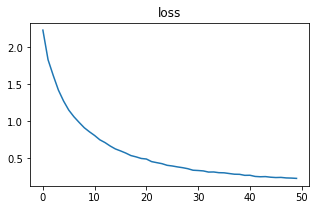

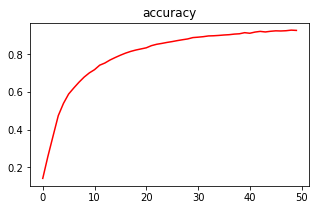

In [21]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'], 'r')
plt.title('accuracy');

In [22]:
# Get Accuracy on test set.

#%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 0s - loss: 1.0212 - accuracy: 0.7293 - 496ms/epoch - 2ms/step
accuracy: 72.93%


In [23]:
# Get Confusion MAtrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

313/313 [==============================] - 0s 979us/step
[[739  22  63  29  28   6   9  10  66  28]
 [  9 861   6  14   2   2   9   1  16  80]
 [ 53   4 581  62 139  74  55  17  14   1]
 [ 11   8  70 559 104 149  65  17   8   9]
 [ 13   2  43  63 775  22  38  36   7   1]
 [  8   2  49 193  75 619  20  26   5   3]
 [  3   5  29  65  60  23 813   0   1   1]
 [  9   2  27  46 110  69   8 725   0   4]
 [ 48  45  19  21  12   1   5   1 827  21]
 [ 22  80   4  40  11   3   6  12  28 794]]

Classification accuracy for each class:

0: 0.7390
1: 0.8610
2: 0.5810
3: 0.5590
4: 0.7750
5: 0.6190
6: 0.8130
7: 0.7250
8: 0.8270
9: 0.7940


In [ ]:
# can't get a test accuracy above 75%, even though the training accuracy can be above 95%.
# Hence I conlcude the current CNN model is overfitting the training data